# 개요

목소리로 성별을 판별할 수 있는 머신러닝 및 딥러닝 모델들을 구현해보았습니다.

# 목소리 데이터 확인

필요한 라이브러리를 불러옵니다.

In [ ]:
# 기본 라이브러리
import os
import warnings 
import numpy as np 
import pandas as pd

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# 머신러닝 라이브러리
import tensorflow as tf
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold
import sklearn.model_selection, sklearn.linear_model, sklearn.svm, sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.svm import SVC

# 딥러닝 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

CSV 파일을 **voice_df** 데이터프레임으로 저장합니다.

In [ ]:
# CSV 파일로 데이터프레임 만들기
voice_df = pd.read_csv('voice.csv')

# 우리 테스트 데이터프레임 만들기
test_df = pd.read_csv('voice_test.csv')

데이터프레임이 잘 만들어졌는지 확인해보고...

In [ ]:
# 데이터프레임이 잘 만들어졌는지 확인하기
voice_df.head() # voice 파일을 불러와서 df라는 파일 이름으로 저장을 하였음.

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


- 0   meanfreq 평균주파수
- 1   sd        주파수의 표준 편차
- 2   median   중앙값
- 3   Q25       첫 번째 분위수(kHz 단위)
- 4   Q75       세 번째 분위수(kHz 단위)
- 5   IQR       분위수 범위(kHz 단위)
- 6   skew      왜곡(스펙프롭 설명의 참고 사항 참조
- 7   kurt      (specprop 설명의 참고 사항 참조)
- 8   sp.ent    스펙트럼 엔트로피
- 9   sfm       스펙트럼 평탄도
- 10  mode      주파수 빈도
- 11  centroid   주파수 중심으로 스펙프로프 참조
- 12  meanfun  음향 신호에서 측정된 기본 주파수의 평균
- 13  minfun    음향 신호에서 측정되는 최소 기본 주파수
- 14  maxfun    음향 신호에서 측정되는 최대 기본 주파수
- 15  meandom   음향 신호에서 측정된 지배적 주파수의 평균
- 16  mindom    음향 신호에서 측정되는 최소 지배적 주파수
- 17  maxdom    음향 신호에서 측정되는 지배적 주파수의 최대
- 18  dfrange   음향 신호에서 측정되는 지배적 주파수 범위
- 19  modindx   변조 인덱스. 기본 주파수의 인접 측정치와 주파수 범위를 나눈 누적된 절대 차이로 계산됩니다.
- 20  label     남녀구분


describe()와 info()를 통해서 전반적으로 데이터를 확인해봅니다.

In [ ]:
voice_df.describe() # df의 값을 대략적으로 요약

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


✅ 목소리 데이터에는 결측치가 없는 것을 확인할 수 있습니다.

In [ ]:
voice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

저희의 타겟 데이터인 성별 label은 object 형태여서 숫자로 바꿔주었습니다.

In [ ]:
# object 형태인 데이터를 숫자로 바꿔주기 - female => 0, male => 1
voice_df.replace(to_replace="female", value=0, inplace=True)
voice_df.replace(to_replace="male", value=1, inplace=True)
voice_df.label.unique() # df의 label명을 여성은 0, 남성은 1로 변환했음.

array([1, 0])

✅ 확인해보니 남자와 여자 데이터의 비율이 같아서 데이터를 나눌 때 비율에 신경쓰지 않아도 됩니다.

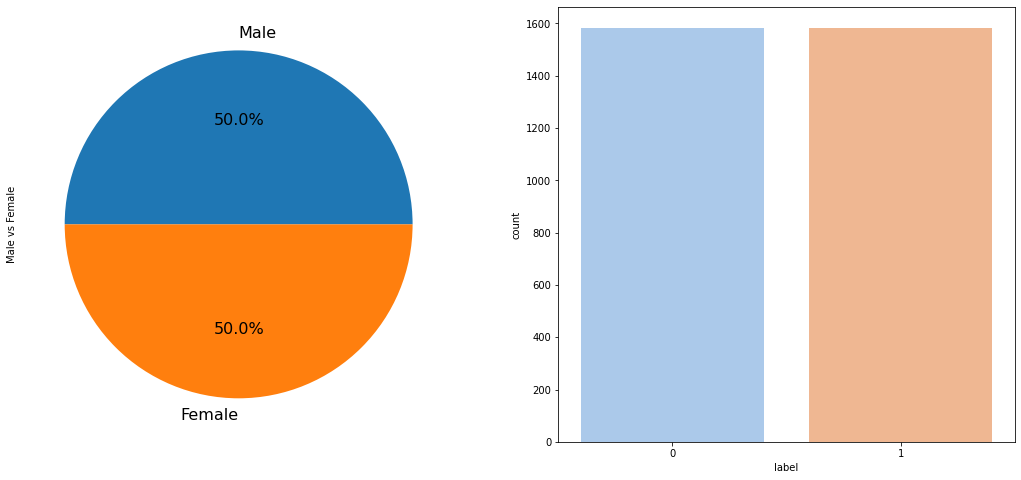

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
voice_df.label.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Male", "Female"],
                                           ylabel="Male vs Female",
                                           autopct='%1.1f%%');

plt.subplot(1, 2, 2)     # 데이터 내에서 Male과 Female의 비중이 얼마나 되는지 확인했습니다. 
sns.countplot(x="label",data=voice_df, palette="pastel")    # 데이터 내에서 Male과 Female의 갯수가 얼마나 되는지 확인해봤습니다.
plt.show()

성별 label 값을 기준으로 해서 어떤 column이 가장 영향을 미칠 수 있는지 heatmap을 통해서 확인을 했지만 유의미한 결과를 확인하기는 어려울 것으로 예상됩니다.

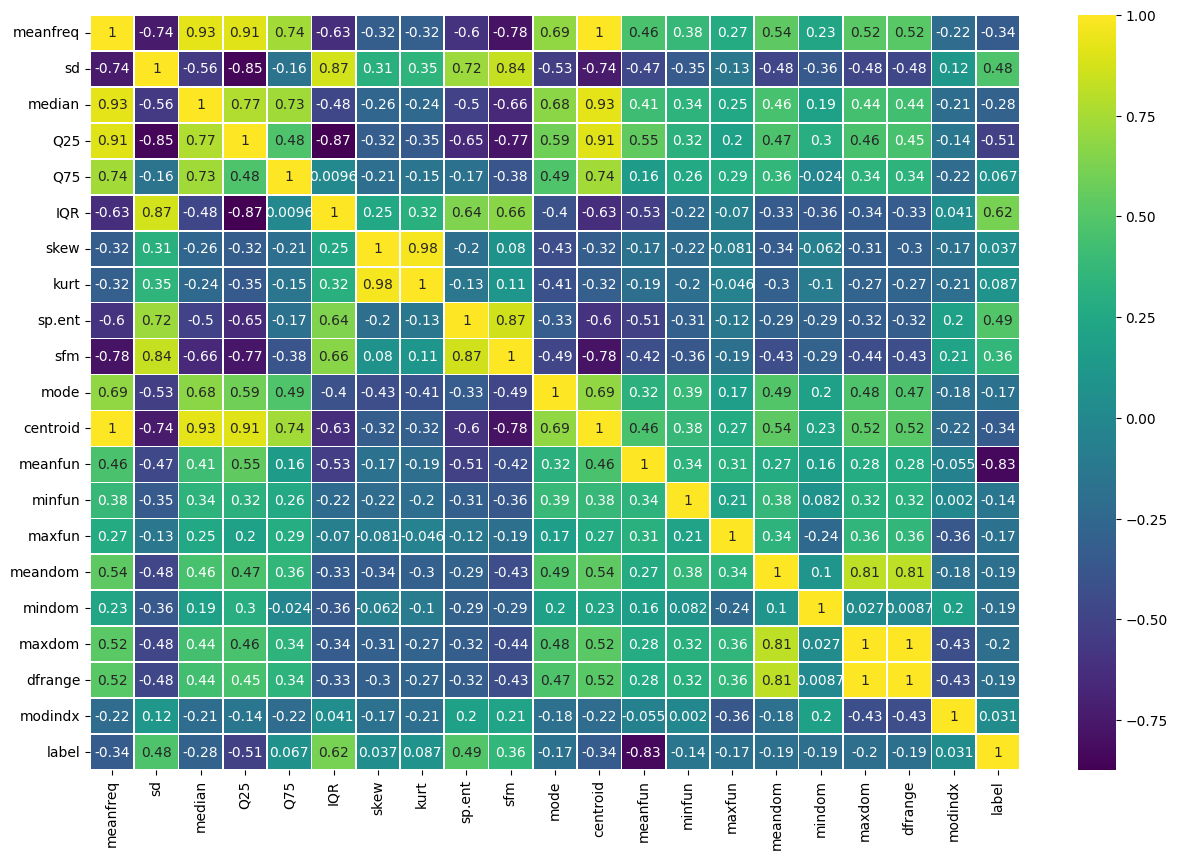

In [ ]:
# 변수 상관관계 확인하기
plt.figure(figsize=(15,10),dpi=100)
sns.heatmap(voice_df.corr(),cmap="viridis",annot=True,linewidth=0.5)

바그래프를 통해 각 피쳐가 label 값을 구분하는데 얼마나 영향력을 미치는지 확인을 했습니다.

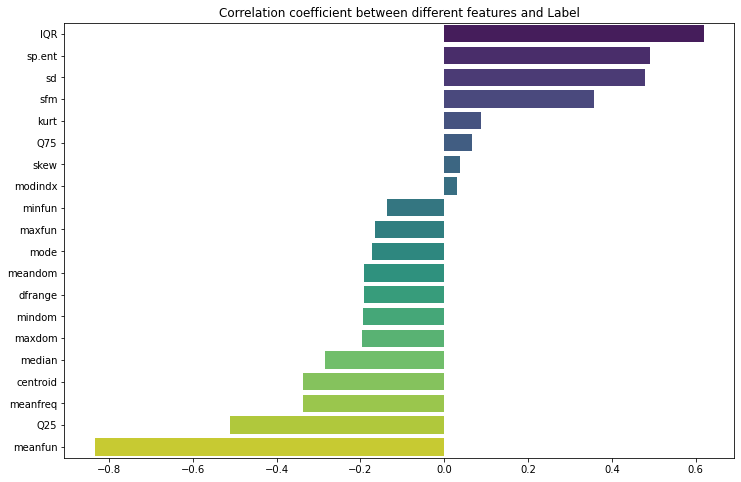

In [ ]:
plt.figure(figsize=(12,8))
data = voice_df.corr()["label"].sort_values(ascending=False)
indices = data.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data[i])
sns.barplot(x=corr, y=labels, palette='viridis')
plt.title('Correlation coefficient between different features and Label')
plt.show()

meanfun(기본 주파수의 평균)이 가장 구분에 영향력이 크다고 생각되어 얼마나 구분이 상세하게 되어있을지를 그래프를 통해서 확인을 해봤습니다.

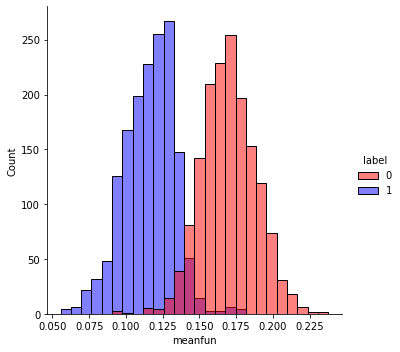

In [ ]:
sns.displot(voice_df, x="meanfun", hue="label",palette=["#ff0000","#0000FF"])

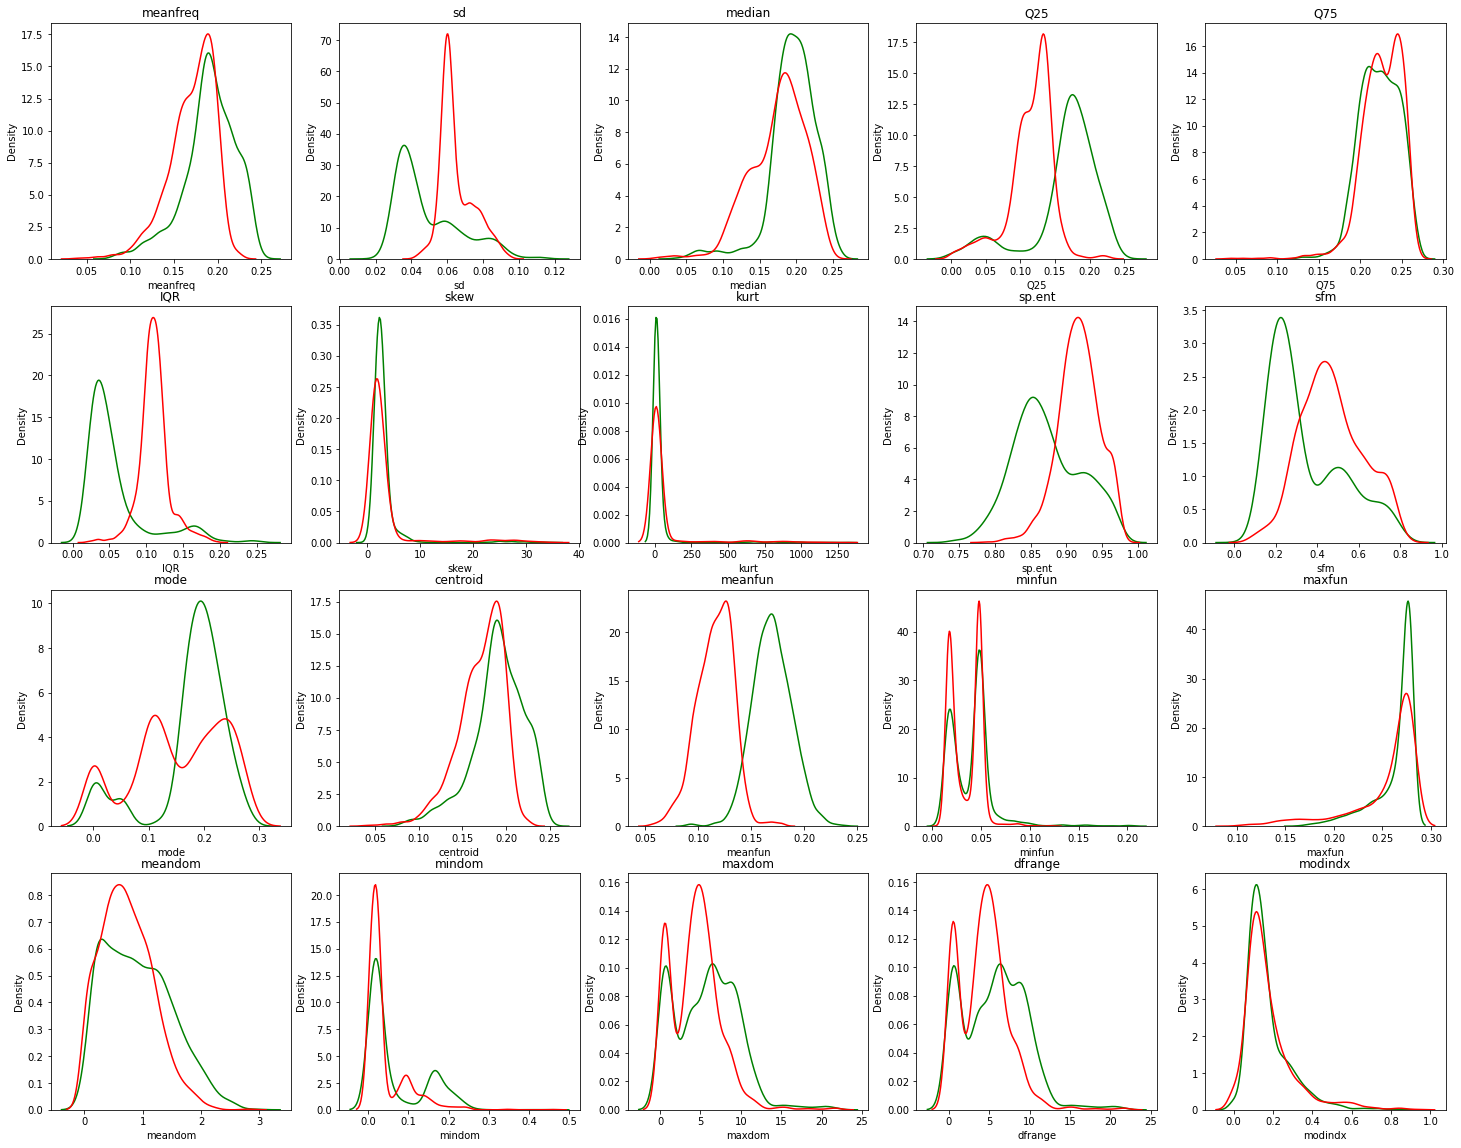

In [ ]:
plt.subplots(4,5,figsize=(25,20))
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.title(voice_df.columns[k-1])
    sns.kdeplot(voice_df.loc[voice_df['label'] == 0, voice_df.columns[k-1]], color= 'green', label='F')
    sns.kdeplot(voice_df.loc[voice_df['label'] == 1, voice_df.columns[k-1]], color= 'red', label='M')

결과적으로 가장 영향을 미치는 독립변수
- 분위수의 범위(IQR) : 상위75% 지점의 값과 하위 25% 지점의 값에 대한 차이
- 1분위값(Q25) : 하위 25%에 대한 값
- 주파수의 평균(meanfun) : 목소리 높이의 평균

위 세개의 요소가 label(성별), 즉 타겟을 잘 설명한다고 생각하여 위 세개의 피쳐를 이용해 머신러닝을 돌려보았습니다.

## 데이터를 분리하였습니다.

In [ ]:
#features = voice_df.iloc[:, :-1]                       # 모든 feature 변수 넣기
features = voice_df.loc[:,['Q25', 'meanfun', 'IQR']]    # 가장 상관관계가 높은 변수만 포함하기
target = voice_df.iloc[:,-1]
features.shape, target.shape
type(features), type(target)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=121)
X_train.shape, y_train.shape

((2534, 3), (2534,))

# 머신러닝 모델 (feature 3개)

**LogisticRegression**

In [ ]:
regressionModel = LogisticRegression()  #로지스틱 회귀방법을 통해 정확도를 예측해봤습니다.
regressionModel.fit(X_train,y_train)
regressionModel.score(X_train,y_train)

0.919889502762431

**KNeighborsClassifier**

In [ ]:
KNNModel = KNeighborsClassifier(n_neighbors=3) # K_neeghbor Classfier를 통해서 정확도를 예측해봤습니다.
KNNModel.fit(X_train,y_train)
KNNModel.score(X_train,y_train)

0.9850039463299132

**Support Vector Machine**
- 분류 과제에 사용할 수 있는 강력한 머신러닝 지도학습 모델
- 2차원에서 기본적으로 두 개의 그룹(데이터)을 분리하는 방법으로 데이터들과 거리가 가장 먼 초평면(hyperplane)을 선택하여 분리하는 방법. 
-즉 분류를 위한 기준 선을 정의하는 모델입니다. 
-그래서 분류되지 않은 새로운 점이 나타나면 경계의 어느 쪽에 속하는지 확인해서 분류 과제를 수행할 수 있게 된다. 
-데이터를 분리하기 위해 직선(경계선)이 필요
-적당한 C값을 찾아나가는 과정 C가 작으면 에러 많이 허용 -> 언더피팅 C가 많으면 에러 거의 없게 -> 오버피팅
-정규분포일때 rbf
-다항식일때 poly

In [ ]:
svmRbfModel=sklearn.svm.SVC(kernel='rbf',C=10) 
svmRbfModel.fit(X_train,y_train)
svmRbfModel.score(X_train,y_train)

0.9798737174427782

In [ ]:
svmPolyModel=sklearn.svm.SVC(kernel='poly',C=10000)
#다항식을 이용할 경우 poly
svmPolyModel.fit(X_train,y_train)
svmPolyModel.score(X_train,y_train)

0.9727703235990529

**RandomForestClassifier**

In [ ]:
randomFModel = RandomForestClassifier(max_depth=3,min_samples_split=2) 
randomFModel.fit(X_train, y_train)
randomFModel.score(X_train,y_train)

0.9723756906077348

**DecisionTreeClassifier**

In [ ]:
dTreeModel = DecisionTreeClassifier(max_depth=3,min_samples_split=2) 
randomFModel.fit(X_train, y_train)
dTreeModel.fit(X_train, y_train)
dTreeModel.score(X_train,y_train)

0.9743488555643252

In [ ]:
trainScores = [regressionModel.score(X_train, y_train), KNNModel.score(X_train, y_train),svmRbfModel.score(X_train, y_train),svmPolyModel.score(X_train, y_train), randomFModel.score(X_train,y_train), dTreeModel.score(X_train,y_train)]
testScores = [regressionModel.score(X_test, y_test), KNNModel.score(X_test, y_test), svmRbfModel.score(X_test, y_test),svmPolyModel.score(X_test, y_test), randomFModel.score(X_test,y_test), dTreeModel.score(X_test,y_test)]
indices = ['Logistic Regression', 'KNN', 'SVM-RBF','SVM-Poly', 'RandomForest', 'DecisionTree']
scores = pd.DataFrame({'Training Score': trainScores,'Testing Score': testScores}, index=indices) #모델별로 train 정확도와 test정확도의 결과값들을 비교해봤습니다.

In [ ]:
scores #정확도의 차이는 이렇게 표로 나타낼 수 있었고

,Training Score,Testing Score
Logistic Regression,0.919890,0.899054
KNN,0.985004,0.955836
SVM-RBF,0.979874,0.962145
SVM-Poly,0.972770,0.952681
RandomForest,0.973165,0.955836
DecisionTree,0.974349,0.955836


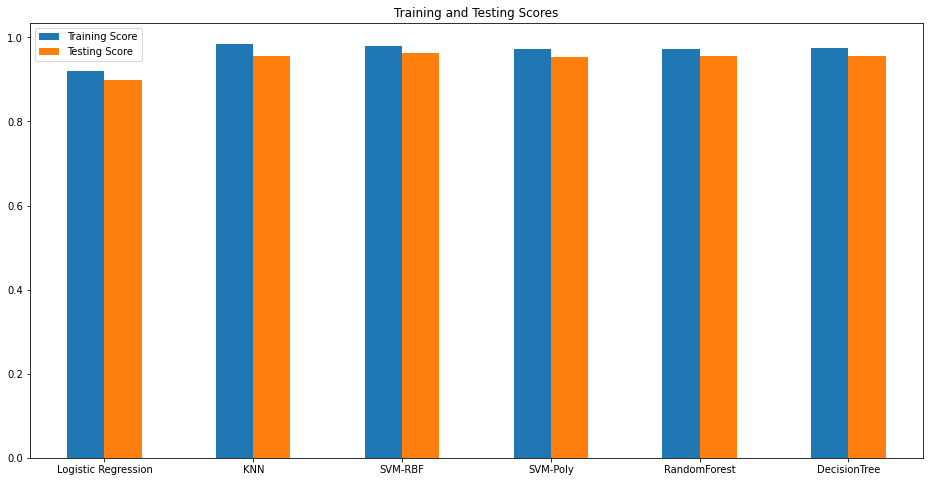

In [ ]:
plot = scores.plot.bar(figsize=(16, 8), rot=0)
plt.title('Training and Testing Scores')
plt.show()  #모델별로 train 정확도와 test의 정확도의 결과값들을 그래프로 나타내봤습니다.

In [ ]:
predRegression = regressionModel.predict(X_test) #xtest의 예측값들을 각 모델별로 확인
predSVMRbf = svmRbfModel.predict(X_test)
predKNN = KNNModel.predict(X_test)
predSVMPoly = svmPolyModel.predict(X_test)
predRandomF = randomFModel.predict(X_test)
predDTree = dTreeModel.predict(X_test)
predVals = pd.DataFrame(data={'truth': y_test, 'regression': predRegression, 'knn': predKNN, 'svm-rbf': predSVMRbf, 'svm-poly': predSVMPoly, 'random-forest': predRandomF, 'decision-tree': predDTree})

## 음성데이터를 통해 확인
학습한 모델이 잘 돌아가는지 확인하기 위해 음성데이터 수집
- 카운터테너 목소리 데이터
- 일반 남자 고음 목소리 데이터
- 일반 남자 저음 목소리 데이터
- 배우 김혜수님 목소리 데이터
- 일반 여자 목소리 데이터
- 짱구 목소리 데이터

## 1차 테스트 (feature 3개로만 예측)

In [ ]:
test_df1 = test_df.copy()

In [ ]:
test_df1.drop(['meanfreq','maxdom','sd','median','Q75','skew','kurt','sp.ent','sfm','mode','centroid','minfun','maxfun','meandom','mindom','dfrange','modindx'], axis = 1,inplace=True)

In [ ]:
pred = KNNModel.predict(test_df1.drop(['label'],axis=1))
pred

array([1, 1, 1, 1, 1, 1])

- 앞선 모델들의 정확도가 높아서 좋아했는데 알고보니 이는 과적합으로 인해 높게 나타나는 결과였다.
- 높은 상관관계를 가지는 feature들을 이용해도 정확도가 낮게 나올 수 있다. ex) 수업시간 타이타닉

**피드백**
- 너무 낮은 변수들로 인해 나타난 과적합 --> 전체 변수들에 대해서 label(성별)과 비교해보았습니다.

# 머신러닝 모델 (모든 feature)

## 데이터를 분리하였습니다.

In [ ]:
# object 형태인 데이터를 숫자로 바꿔주기 - female => 0, male => 1
voice_df.replace(to_replace="female", value=0, inplace=True)
voice_df.replace(to_replace="male", value=1, inplace=True)
voice_df.label.unique() # df의 label명을 여성은 0, 남성은 1로 변환했음.

array([1, 0])

In [ ]:
features = voice_df.iloc[:, :-1]                       # 모든 feature 변수 넣기
#features = voice_df.loc[:,['Q25', 'meanfun', 'IQR']]    
target = voice_df.iloc[:,-1]
features.shape, target.shape
type(features), type(target)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=121)
X_train.shape, y_train.shape

((2534, 20), (2534,))

## 데이터 다시 돌리기

**LogisticRegression**

In [ ]:
regressionModel = LogisticRegression()  #로지스틱 회귀방법을 통해 정확도를 예측해봤습니다.
regressionModel.fit(X_train,y_train)
regressionModel.score(X_train,y_train)

0.9088397790055248

**KNeighborsClassifier**

In [ ]:
KNNModel = KNeighborsClassifier(n_neighbors=3) # K_neeghbor Classfier를 통해서 정확도를 예측해봤습니다.
KNNModel.fit(X_train,y_train)
KNNModel.score(X_train,y_train)

0.8579321231254933

**Support Vector Machine**

In [ ]:
svmRbfModel=sklearn.svm.SVC(kernel='rbf',C=10) 
svmRbfModel.fit(X_train,y_train)
svmRbfModel.score(X_train,y_train)

0.6890292028413575

In [ ]:
svmPolyModel=sklearn.svm.SVC(kernel='poly',C=10000)
#다항식을 이용할 경우 poly
svmPolyModel.fit(X_train,y_train)
svmPolyModel.score(X_train,y_train)

0.6377269139700079

**RandomForestClassifier**

In [ ]:
randomFModel = RandomForestClassifier(max_depth=3,min_samples_split=2) 
randomFModel.fit(X_train, y_train)
randomFModel.score(X_train,y_train)

0.9771112865035517

**DecisionTreeClassifier**

In [ ]:
dTreeModel = DecisionTreeClassifier(max_depth=3,min_samples_split=2)   
randomFModel.fit(X_train, y_train)
dTreeModel.fit(X_train, y_train)
dTreeModel.score(X_train,y_train)

0.9755327545382794

In [ ]:
trainScores = [regressionModel.score(X_train, y_train), KNNModel.score(X_train, y_train),svmRbfModel.score(X_train, y_train),svmPolyModel.score(X_train, y_train), randomFModel.score(X_train,y_train), dTreeModel.score(X_train,y_train)]
testScores = [regressionModel.score(X_test, y_test), KNNModel.score(X_test, y_test), svmRbfModel.score(X_test, y_test),svmPolyModel.score(X_test, y_test), randomFModel.score(X_test,y_test), dTreeModel.score(X_test,y_test)]
indices = ['Logistic Regression', 'KNN', 'SVM-RBF','SVM-Poly', 'RandomForest', 'DecisionTree']
scores = pd.DataFrame({'Training Score': trainScores,'Testing Score': testScores}, index=indices) #모델별로 train 정확도와 test정확도의 결과값들을 비교해봤습니다.

In [ ]:
scores #정화도의 차이는 이렇게 표로 나타낼 수 있었고

,Training Score,Testing Score
Logistic Regression,0.908840,0.878549
KNN,0.857932,0.697161
SVM-RBF,0.689029,0.668770
SVM-Poly,0.637727,0.659306
RandomForest,0.972770,0.955836
DecisionTree,0.975533,0.955836


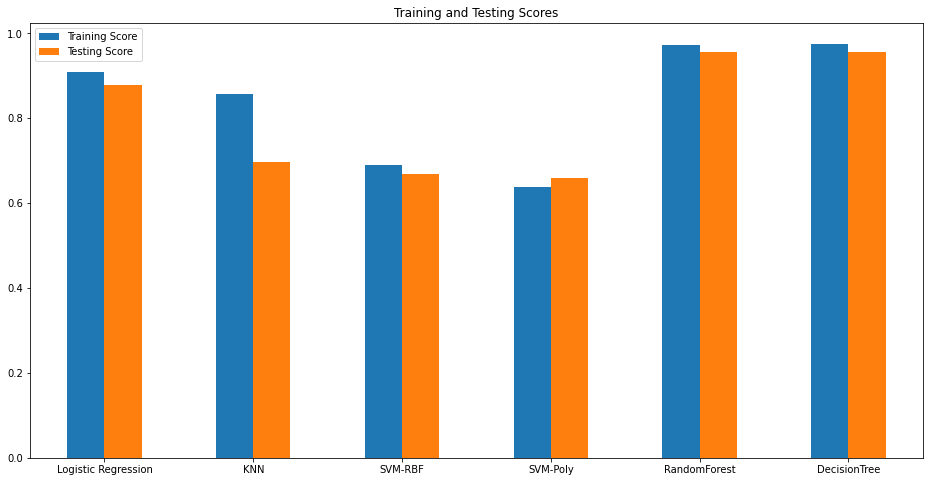

In [ ]:
plot = scores.plot.bar(figsize=(16, 8), rot=0)
plt.title('Training and Testing Scores')
plt.show()  #모델별로 train 정확도와 test의 정확도의 결과값들을 그래프로 나타내봤습니다.

In [ ]:
predRegression = regressionModel.predict(X_test) #xtest의 예측값들을 각 모델별로 확인
predSVMRbf = svmRbfModel.predict(X_test)
predKNN = KNNModel.predict(X_test)
predSVMPoly = svmPolyModel.predict(X_test)
predRandomF = randomFModel.predict(X_test)
predDTree = dTreeModel.predict(X_test)
predVals = pd.DataFrame(data={'truth': y_test, 'regression': predRegression, 'knn': predKNN, 'svm-rbf': predSVMRbf, 'svm-poly': predSVMPoly, 'random-forest': predRandomF, 'decision-tree': predDTree})

## 음성데이터를 통해 확인
학습한 모델이 잘 돌아가는지 확인하기 위해 음성데이터 수집
- 카운터테너 목소리 데이터
- 일반 남자 고음 목소리 데이터
- 일반 남자 저음 목소리 데이터
- 배우 김혜수님 목소리 데이터
- 일반 여자 목소리 데이터
- 짱구 목소리 데이터

## 2차 테스트 (전체 feature로 예측)

In [ ]:
test_df2 = test_df.copy()

In [ ]:
# object 형태인 데이터를 숫자로 바꿔주기 - female => 0, male => 1
test_df2.replace(to_replace="female", value=0, inplace=True)
test_df2.replace(to_replace="male", value=1, inplace=True)
test_df2.label.unique() # df의 label명을 여성은 0, 남성은 1로 변환했음.

array([1, 0])

In [ ]:
pred = dTreeModel.predict(test_df2.drop(['label'],axis=1))
pred

array([1, 0, 1, 0, 0, 0])

In [ ]:
accuracy_score((test_df2.label), pred)

0.8333333333333334

# 딥러닝 모델

## Sigmoid 모델

In [ ]:
# relu -> sigmoid & dropout 세줄에 한번 추가
model = Sequential()
model.add(Dense(256, input_shape=(20,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# sigmoid와 binary crossentropy를 이용한 이유는 male/female 2개의 바이너리이기 때문에

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam(lr=0.001))

model.fit(X_train, y_train, epochs=100,
          batch_size=64, validation_split=0.25,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
30/30 [==============================] - 1s 13ms/step - loss: 0.7870 - accuracy: 0.4984 - val_loss: 0.6791 - val_accuracy: 0.5110
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 0.7954 - accuracy: 0.5084 - val_loss: 0.6807 - val_accuracy: 0.5016
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7584 - accuracy: 0.5095 - val_loss: 0.7473 - val_accuracy: 0.5363
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 0.7348 - accuracy: 0.5358 - val_loss: 0.6610 - val_accuracy: 0.5063
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5874 - val_loss: 0.6444 - val_accuracy: 0.6278
Epoch 6/100
30/30 [==============================] - 0s 6ms/step - loss: 0.6518 - accuracy: 0.6142 - val_loss: 0.6330 - val_accuracy: 0.6404
Epoch 7/100
30/30 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.6553 - val_loss: 0.5695 - val_accuracy: 0.7334
Epoch 8/100


In [ ]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(X_test)} samples...")
loss, accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 634 samples...
Loss: 0.1439
Accuracy: 94.16%


## 음성데이터를 통해 확인
학습한 모델이 잘 돌아가는지 확인하기 위해 음성데이터 수집
- 카운터테너 목소리 데이터
- 일반 남자 고음 목소리 데이터
- 일반 남자 저음 목소리 데이터
- 배우 김혜수님 목소리 데이터
- 일반 여자 목소리 데이터
- 짱구 목소리 데이터

### 2차 테스트 예측 결과 (sigmoid)

In [ ]:
test_df2.label

0    1
1    1
2    1
3    0
4    0
5    0
Name: label, dtype: int64

In [ ]:
pred = model.predict(test_df2.drop(['label'],axis=1))
# 0,0,1,0,0,0      # 1,1,1,0,0,0
# 남자를 잘 못 맞혔다

array([[3.5717976e-01],
       [1.6104305e-01],
       [9.9165469e-01],
       [3.8860559e-02],
       [1.4352798e-04],
       [2.2471845e-03]], dtype=float32)

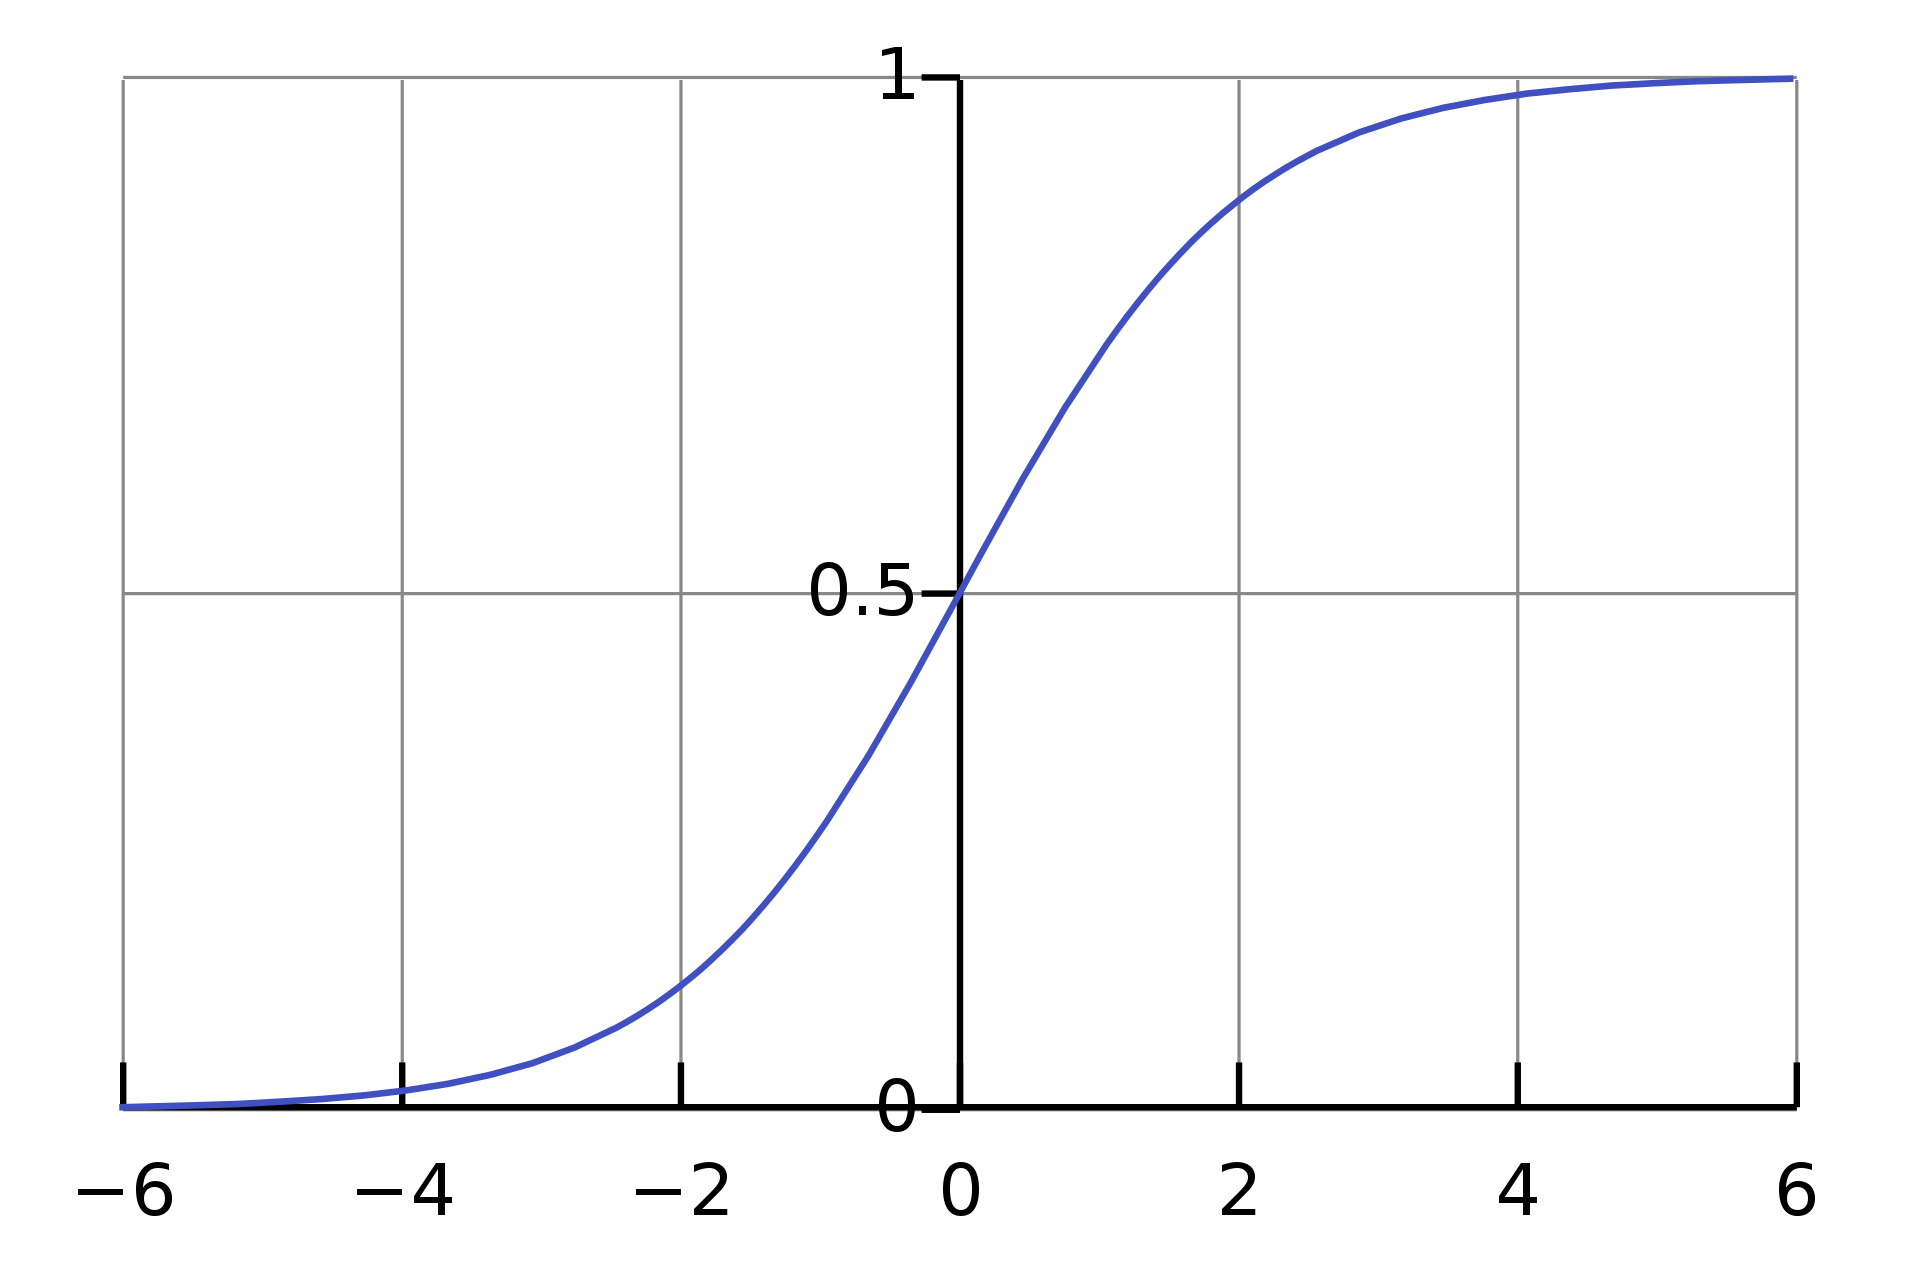

In [ ]:
# 테스트한
print(f"Evaluating the model using {len(X_test)} samples...")
loss, accuracy = model.evaluate(test_df2.drop(['label'],axis=1), test_df2.label, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 634 samples...
Loss: 0.4843
Accuracy: 66.67%


## Softmax 모델

In [ ]:
# relu -> softmax & dropout
model = Sequential()
model.add(Dense(256, input_shape=(20,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.fit(X_train, y_train, epochs=100,
          batch_size=64,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
33/40 [=======================>......] - ETA: 0s - loss: 0.9581 - accuracy: 0.5062

40/40 [==============================] - 1s 5ms/step - loss: 0.9312 - accuracy: 0.5138
Epoch 2/100
38/40 [===========================>..] - ETA: 0s - loss: 0.7357 - accuracy: 0.5469

40/40 [==============================] - 0s 6ms/step - loss: 0.7380 - accuracy: 0.5485
Epoch 3/100
33/40 [=======================>......] - ETA: 0s - loss: 0.6941 - accuracy: 0.6359

40/40 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.6369
Epoch 4/100
39/40 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.6635

40/40 [==============================] - 0s 6ms/step - loss: 0.6266 - accuracy: 0.6646
Epoch 5/100
40/40 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7017

40/40 [==============================] - 0s 6ms/step - loss: 0.5799 - accuracy: 0.7017
Epoch 6/100
35/40 [=========================>....] - ETA: 0s - loss: 0.5582 - accuracy: 0.7165

40/40 [==============================] - 0s 7ms/step - loss: 0.5519 - accuracy: 0.7190
Epoch 7/100
36/40 [==========================>...] - ETA: 0s - loss: 0.5397 - accuracy: 0.7296

40/40 [==============================] - 0s 6ms/step - loss: 0.5327 - accuracy: 0.7344
Epoch 8/100
35/40 [=========================>....] - ETA: 0s - loss: 0.5076 - accuracy: 0.7696

40/40 [==============================] - 0s 6ms/step - loss: 0.5077 - accuracy: 0.7699
Epoch 9/100
36/40 [==========================>...] - ETA: 0s - loss: 0.4780 - accuracy: 0.7812

40/40 [==============================] - 0s 6ms/step - loss: 0.4800 - accuracy: 0.7766
Epoch 10/100
31/40 [======================>.......] - ETA: 0s - loss: 0.4830 - accuracy: 0.7742

40/40 [==============================] - 0s 5ms/step - loss: 0.4646 - accuracy: 0.7885
Epoch 11/100
32/40 [=======================>......] - ETA: 0s - loss: 0.4478 - accuracy: 0.7983

40/40 [==============================] - 0s 5ms/step - loss: 0.4386 - accuracy: 0.8031
Epoch 12/100
38/40 [===========================>..] - ETA: 0s - loss: 0.4101 - accuracy: 0.8195

40/40 [==============================] - 0s 4ms/step - loss: 0.4100 - accuracy: 0.8181
Epoch 13/100
34/40 [========================>.....] - ETA: 0s - loss: 0.4131 - accuracy: 0.8153

40/40 [==============================] - 0s 5ms/step - loss: 0.4155 - accuracy: 0.8137
Epoch 14/100
36/40 [==========================>...] - ETA: 0s - loss: 0.3869 - accuracy: 0.8325

40/40 [==============================] - 0s 5ms/step - loss: 0.3885 - accuracy: 0.8331
Epoch 15/100
34/40 [========================>.....] - ETA: 0s - loss: 0.3514 - accuracy: 0.8470

40/40 [==============================] - 0s 5ms/step - loss: 0.3498 - accuracy: 0.8500
Epoch 16/100
34/40 [========================>.....] - ETA: 0s - loss: 0.3367 - accuracy: 0.8580

40/40 [==============================] - 0s 5ms/step - loss: 0.3273 - accuracy: 0.8619
Epoch 17/100
28/40 [====================>.........] - ETA: 0s - loss: 0.3019 - accuracy: 0.8800

40/40 [==============================] - 0s 4ms/step - loss: 0.3124 - accuracy: 0.8749
Epoch 18/100
32/40 [=======================>......] - ETA: 0s - loss: 0.3274 - accuracy: 0.8540

40/40 [==============================] - 0s 3ms/step - loss: 0.3281 - accuracy: 0.8560
Epoch 19/100
33/40 [=======================>......] - ETA: 0s - loss: 0.2964 - accuracy: 0.8717

40/40 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.8749
Epoch 20/100
30/40 [=====================>........] - ETA: 0s - loss: 0.2652 - accuracy: 0.8990

40/40 [==============================] - 0s 4ms/step - loss: 0.2642 - accuracy: 0.8974
Epoch 21/100
31/40 [======================>.......] - ETA: 0s - loss: 0.2348 - accuracy: 0.9103

40/40 [==============================] - 0s 4ms/step - loss: 0.2375 - accuracy: 0.9088
Epoch 22/100
31/40 [======================>.......] - ETA: 0s - loss: 0.2481 - accuracy: 0.9042

40/40 [==============================] - 0s 4ms/step - loss: 0.2444 - accuracy: 0.9049
Epoch 23/100
29/40 [====================>.........] - ETA: 0s - loss: 0.2443 - accuracy: 0.9057

40/40 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.9081
Epoch 24/100
33/40 [=======================>......] - ETA: 0s - loss: 0.3995 - accuracy: 0.8362

40/40 [==============================] - 0s 3ms/step - loss: 0.3804 - accuracy: 0.8441
Epoch 25/100
32/40 [=======================>......] - ETA: 0s - loss: 0.2426 - accuracy: 0.9019

40/40 [==============================] - 0s 4ms/step - loss: 0.2437 - accuracy: 0.9013
Epoch 26/100
30/40 [=====================>........] - ETA: 0s - loss: 0.2431 - accuracy: 0.9021

40/40 [==============================] - 0s 4ms/step - loss: 0.2451 - accuracy: 0.8966
Epoch 27/100
29/40 [====================>.........] - ETA: 0s - loss: 0.2369 - accuracy: 0.9019

40/40 [==============================] - 0s 4ms/step - loss: 0.2416 - accuracy: 0.9009
Epoch 28/100
32/40 [=======================>......] - ETA: 0s - loss: 0.2307 - accuracy: 0.9111

40/40 [==============================] - 0s 4ms/step - loss: 0.2307 - accuracy: 0.9136
Epoch 29/100
30/40 [=====================>........] - ETA: 0s - loss: 0.2074 - accuracy: 0.9177

40/40 [==============================] - 0s 4ms/step - loss: 0.2068 - accuracy: 0.9211
Epoch 30/100
33/40 [=======================>......] - ETA: 0s - loss: 0.2153 - accuracy: 0.9167

40/40 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.9155
Epoch 31/100
31/40 [======================>.......] - ETA: 0s - loss: 0.2175 - accuracy: 0.9123

40/40 [==============================] - 0s 4ms/step - loss: 0.2272 - accuracy: 0.9084
Epoch 32/100
31/40 [======================>.......] - ETA: 0s - loss: 0.2019 - accuracy: 0.9264

40/40 [==============================] - 0s 4ms/step - loss: 0.1991 - accuracy: 0.9274
Epoch 33/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1949 - accuracy: 0.9228

40/40 [==============================] - 0s 5ms/step - loss: 0.1896 - accuracy: 0.9258
Epoch 34/100
30/40 [=====================>........] - ETA: 0s - loss: 0.1666 - accuracy: 0.9406

40/40 [==============================] - 0s 4ms/step - loss: 0.1726 - accuracy: 0.9392
Epoch 35/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1904 - accuracy: 0.9248

40/40 [==============================] - 0s 4ms/step - loss: 0.1881 - accuracy: 0.9274
Epoch 36/100
31/40 [======================>.......] - ETA: 0s - loss: 0.2022 - accuracy: 0.9304

40/40 [==============================] - 0s 4ms/step - loss: 0.2025 - accuracy: 0.9274
Epoch 37/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1710 - accuracy: 0.9390

40/40 [==============================] - 0s 4ms/step - loss: 0.1693 - accuracy: 0.9388
Epoch 38/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1901 - accuracy: 0.9316

40/40 [==============================] - 0s 4ms/step - loss: 0.1974 - accuracy: 0.9278
Epoch 39/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1980 - accuracy: 0.9299

40/40 [==============================] - 0s 3ms/step - loss: 0.1991 - accuracy: 0.9262
Epoch 40/100
30/40 [=====================>........] - ETA: 0s - loss: 0.2705 - accuracy: 0.8927

40/40 [==============================] - 0s 4ms/step - loss: 0.2704 - accuracy: 0.8891
Epoch 41/100
32/40 [=======================>......] - ETA: 0s - loss: 0.2161 - accuracy: 0.9224

40/40 [==============================] - 0s 3ms/step - loss: 0.2093 - accuracy: 0.9211
Epoch 42/100
30/40 [=====================>........] - ETA: 0s - loss: 0.2209 - accuracy: 0.9057

40/40 [==============================] - 0s 4ms/step - loss: 0.2175 - accuracy: 0.9061
Epoch 43/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1759 - accuracy: 0.9238

40/40 [==============================] - 0s 4ms/step - loss: 0.1646 - accuracy: 0.9309
Epoch 44/100
35/40 [=========================>....] - ETA: 0s - loss: 0.1796 - accuracy: 0.9344

40/40 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9373
Epoch 45/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1765 - accuracy: 0.9375

40/40 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9353
Epoch 46/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1624 - accuracy: 0.9394

40/40 [==============================] - 0s 4ms/step - loss: 0.1591 - accuracy: 0.9408
Epoch 47/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1463 - accuracy: 0.9458

40/40 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.9404
Epoch 48/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1575 - accuracy: 0.9418

40/40 [==============================] - 0s 3ms/step - loss: 0.1620 - accuracy: 0.9424
Epoch 49/100
35/40 [=========================>....] - ETA: 0s - loss: 0.1570 - accuracy: 0.9429

40/40 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9428
Epoch 50/100
35/40 [=========================>....] - ETA: 0s - loss: 0.1422 - accuracy: 0.9491

40/40 [==============================] - 0s 3ms/step - loss: 0.1420 - accuracy: 0.9503
Epoch 51/100
36/40 [==========================>...] - ETA: 0s - loss: 0.1779 - accuracy: 0.9314

40/40 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9305
Epoch 52/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1419 - accuracy: 0.9453

40/40 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9444
Epoch 53/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1702 - accuracy: 0.9385

40/40 [==============================] - 0s 4ms/step - loss: 0.1616 - accuracy: 0.9416
Epoch 54/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1344 - accuracy: 0.9550

40/40 [==============================] - 0s 3ms/step - loss: 0.1383 - accuracy: 0.9534
Epoch 55/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1216 - accuracy: 0.9614

40/40 [==============================] - 0s 3ms/step - loss: 0.1266 - accuracy: 0.9590
Epoch 56/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1516 - accuracy: 0.9441

40/40 [==============================] - 0s 3ms/step - loss: 0.1441 - accuracy: 0.9467
Epoch 57/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1155 - accuracy: 0.9573

40/40 [==============================] - 0s 3ms/step - loss: 0.1162 - accuracy: 0.9562
Epoch 58/100
36/40 [==========================>...] - ETA: 0s - loss: 0.1162 - accuracy: 0.9579

40/40 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.9558
Epoch 59/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1429 - accuracy: 0.9481

40/40 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9491
Epoch 60/100
36/40 [==========================>...] - ETA: 0s - loss: 0.1366 - accuracy: 0.9475

40/40 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9471
Epoch 61/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1313 - accuracy: 0.9536

40/40 [==============================] - 0s 3ms/step - loss: 0.1341 - accuracy: 0.9507
Epoch 62/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1362 - accuracy: 0.9531

40/40 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9538
Epoch 63/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1423 - accuracy: 0.9470

40/40 [==============================] - 0s 3ms/step - loss: 0.1438 - accuracy: 0.9467
Epoch 64/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1557 - accuracy: 0.9410

40/40 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9440
Epoch 65/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9466

40/40 [==============================] - 0s 4ms/step - loss: 0.1517 - accuracy: 0.9388
Epoch 66/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1581 - accuracy: 0.9441

40/40 [==============================] - 0s 4ms/step - loss: 0.1476 - accuracy: 0.9463
Epoch 67/100
27/40 [===================>..........] - ETA: 0s - loss: 0.1230 - accuracy: 0.9508

40/40 [==============================] - 0s 4ms/step - loss: 0.1324 - accuracy: 0.9471
Epoch 68/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1163 - accuracy: 0.9580

40/40 [==============================] - 0s 3ms/step - loss: 0.1147 - accuracy: 0.9582
Epoch 69/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1159 - accuracy: 0.9555

40/40 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9550
Epoch 70/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1143 - accuracy: 0.9536

40/40 [==============================] - 0s 4ms/step - loss: 0.1194 - accuracy: 0.9530
Epoch 71/100
29/40 [====================>.........] - ETA: 0s - loss: 0.1189 - accuracy: 0.9558

40/40 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.9601
Epoch 72/100
30/40 [=====================>........] - ETA: 0s - loss: 0.1066 - accuracy: 0.9604

40/40 [==============================] - 0s 4ms/step - loss: 0.1015 - accuracy: 0.9633
Epoch 73/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1033 - accuracy: 0.9637

40/40 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9617
Epoch 74/100
32/40 [=======================>......] - ETA: 0s - loss: 0.1126 - accuracy: 0.9561

40/40 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.9546
Epoch 75/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1393 - accuracy: 0.9458

40/40 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9463
Epoch 76/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1242 - accuracy: 0.9522

40/40 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.9542
Epoch 77/100
37/40 [==========================>...] - ETA: 0s - loss: 0.1227 - accuracy: 0.9506

40/40 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.9503
Epoch 78/100
35/40 [=========================>....] - ETA: 0s - loss: 0.1106 - accuracy: 0.9558

40/40 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.9562
Epoch 79/100
36/40 [==========================>...] - ETA: 0s - loss: 0.1168 - accuracy: 0.9562

40/40 [==============================] - 0s 3ms/step - loss: 0.1189 - accuracy: 0.9554
Epoch 80/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1296 - accuracy: 0.9531

40/40 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.9550
Epoch 81/100
33/40 [=======================>......] - ETA: 0s - loss: 0.1018 - accuracy: 0.9621

40/40 [==============================] - 0s 3ms/step - loss: 0.0980 - accuracy: 0.9629
Epoch 82/100
34/40 [========================>.....] - ETA: 0s - loss: 0.1112 - accuracy: 0.9591

40/40 [==============================] - 0s 3ms/step - loss: 0.1178 - accuracy: 0.9562
Epoch 83/100
31/40 [======================>.......] - ETA: 0s - loss: 0.1316 - accuracy: 0.9506

40/40 [==============================] - 0s 4ms/step - loss: 0.1256 - accuracy: 0.9530
Epoch 84/100
30/40 [=====================>........] - ETA: 0s - loss: 0.0960 - accuracy: 0.9651

40/40 [==============================] - 0s 4ms/step - loss: 0.1020 - accuracy: 0.9629
Epoch 85/100
35/40 [=========================>....] - ETA: 0s - loss: 0.0973 - accuracy: 0.9634

40/40 [==============================] - 0s 5ms/step - loss: 0.0980 - accuracy: 0.9629
Epoch 86/100
40/40 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9546

40/40 [==============================] - 0s 6ms/step - loss: 0.1047 - accuracy: 0.9546
Epoch 87/100
39/40 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9619

40/40 [==============================] - 0s 6ms/step - loss: 0.0988 - accuracy: 0.9621
Epoch 88/100
37/40 [==========================>...] - ETA: 0s - loss: 0.0934 - accuracy: 0.9679

40/40 [==============================] - 0s 7ms/step - loss: 0.0942 - accuracy: 0.9669
Epoch 89/100
39/40 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9479

40/40 [==============================] - 0s 6ms/step - loss: 0.1376 - accuracy: 0.9487
Epoch 90/100
40/40 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9645

40/40 [==============================] - 0s 8ms/step - loss: 0.0996 - accuracy: 0.9645
Epoch 91/100
37/40 [==========================>...] - ETA: 0s - loss: 0.1074 - accuracy: 0.9611

40/40 [==============================] - 0s 6ms/step - loss: 0.1072 - accuracy: 0.9609
Epoch 92/100
33/40 [=======================>......] - ETA: 0s - loss: 0.0949 - accuracy: 0.9678

40/40 [==============================] - 0s 7ms/step - loss: 0.0978 - accuracy: 0.9669
Epoch 93/100
31/40 [======================>.......] - ETA: 0s - loss: 0.0937 - accuracy: 0.9652

40/40 [==============================] - 0s 6ms/step - loss: 0.0981 - accuracy: 0.9637
Epoch 94/100
38/40 [===========================>..] - ETA: 0s - loss: 0.1016 - accuracy: 0.9634

40/40 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9633
Epoch 95/100
35/40 [=========================>....] - ETA: 0s - loss: 0.1244 - accuracy: 0.9531

40/40 [==============================] - 0s 6ms/step - loss: 0.1284 - accuracy: 0.9495
Epoch 96/100
38/40 [===========================>..] - ETA: 0s - loss: 0.1271 - accuracy: 0.9498

40/40 [==============================] - 0s 6ms/step - loss: 0.1235 - accuracy: 0.9515
Epoch 97/100
38/40 [===========================>..] - ETA: 0s - loss: 0.1028 - accuracy: 0.9626

40/40 [==============================] - 0s 9ms/step - loss: 0.1009 - accuracy: 0.9633
Epoch 98/100
39/40 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9563

40/40 [==============================] - 0s 6ms/step - loss: 0.1125 - accuracy: 0.9566
Epoch 99/100
38/40 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.9576

40/40 [==============================] - 0s 6ms/step - loss: 0.1166 - accuracy: 0.9578
Epoch 100/100
38/40 [===========================>..] - ETA: 0s - loss: 0.1009 - accuracy: 0.9671

40/40 [==============================] - 0s 6ms/step - loss: 0.0998 - accuracy: 0.9665


In [ ]:
# 평가하는 세트
print(f"Evaluating the model using {len(X_test)} samples...")
loss, accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 634 samples...
Loss: 0.1686
Accuracy: 94.01%


### 2차 테스트 예측 결과 (softmax)

In [ ]:
pred = model.predict(test_df2.drop(['label'],axis=1))
pred
# 0,0,1,0,0,0

array([[7.6749623e-01, 2.3250371e-01],
       [8.5192752e-01, 1.4807250e-01],
       [2.6076129e-03, 9.9739242e-01],
       [5.7367176e-01, 4.2632824e-01],
       [9.9943155e-01, 5.6848244e-04],
       [9.8048556e-01, 1.9514462e-02]], dtype=float32)

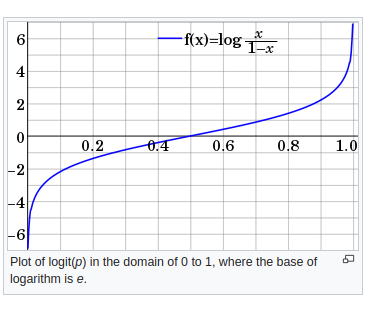

In [ ]:
# 평가하는 세트
print(f"Evaluating the model using {len(X_test)} samples...")
loss, accuracy = model.evaluate(test_df2.drop(['label'],axis=1), test_df2.label, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 634 samples...
Loss: 0.6579
Accuracy: 66.67%


# 🐳 결론

- 머신러닝 모델인 DecisionTreeClassifier의 결과값은 [1, 0, 1, 0, 0, 0], 정확도는 83.3% --> 일반 남자 고음 목소리 데이터 구별 못함
- 딥러닝 모델 결과값은 [0 ,0 ,1, 0, 0, 0], 정확도는 66% --> 일반 남자 저음 목소리 데이터만 구별함
- 딥러닝이 머신러닝보다 더 발전됐다 믿었으나 예상외에 결과를 보였다.
- 데이터가 적을 때는 머신러닝이 효율적인 모습을 보였다.